## Credit Card Customer Segmentation

Goal of this project is to cluster the credit card customers based on their spending.

In [12]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

In [15]:
# read the dataset
df = pd.read_csv("Data/CC GENERAL.csv", sep=",", encoding="ISO-8859-1", header=0)
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [16]:
# Print the Pandas dataframe profile
profile = pp.ProfileReport(df)
profile.to_file("df_profile.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 17.65it/s]


In [4]:
print(f'shape of the dataset: {df.shape}')
print(f'\nColumns: {df.columns}')
print(f'\nshape of the dataset: \n{df.describe}')

shape of the dataset: (8950, 18)

Columns: Index(['CUST_ID', 'BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'],
      dtype='object')

shape of the dataset: 
<bound method NDFrame.describe of      CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0     C10001    40.900749           0.818182      95.40              0.00   
1     C10002  3202.467416           0.909091       0.00              0.00   
2     C10003  2495.148862           1.000000     773.17            773.17   
3     C10004  1666.670542           0.636364    1499.00           1499.00   
4     C10005   817.714335           1.000000      16.00             16.00   
...      ...          ..

In [17]:
print(f'shape of the original dataset: {df.shape}')
# Drop the missing data rows
df = df.dropna()
print(f'\nShape of the dataset after cleanup: {df.shape}')

shape of the original dataset: (8950, 18)

Shape of the dataset after cleanup: (8636, 18)


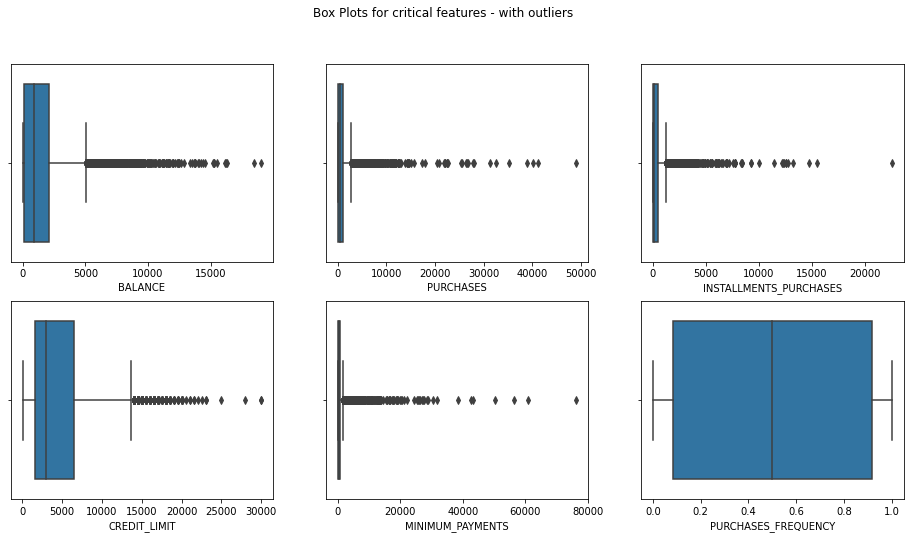

In [8]:
fig, axs = plt.subplots(2,3, figsize=(16,8))
sns.boxplot(x="BALANCE", data=df, ax=axs[0][0])
sns.boxplot(x="PURCHASES", data=df,  ax=axs[0][1])
sns.boxplot(x="INSTALLMENTS_PURCHASES", data=df, ax=axs[0][2])
sns.boxplot(x="CREDIT_LIMIT", data=df, ax=axs[1][0])
sns.boxplot(x="MINIMUM_PAYMENTS", data=df, ax=axs[1][1])
sns.boxplot(x="PURCHASES_FREQUENCY", data=df, ax=axs[1][2])
fig.suptitle('Box Plots for critical features - with outliers')
plt.show()

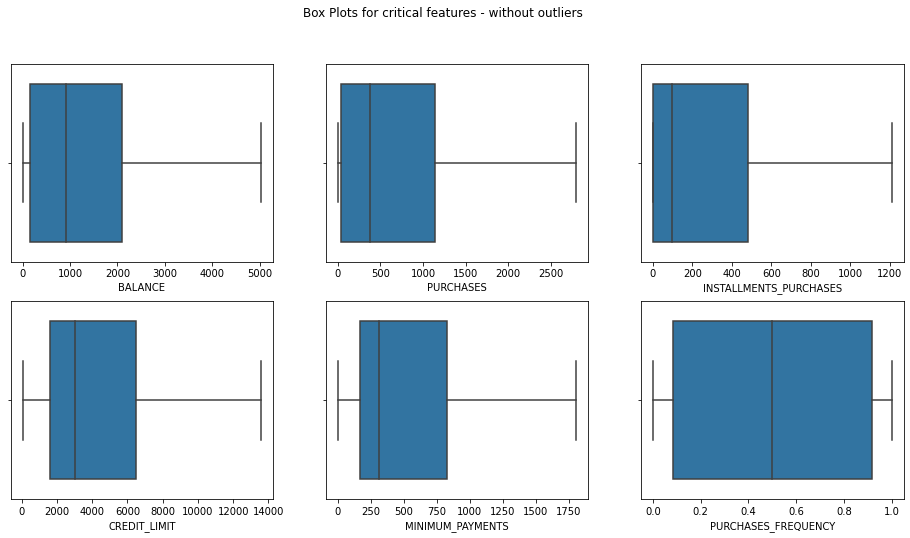

In [9]:
fig, axs = plt.subplots(2,3, figsize=(16,8))
sns.boxplot(x="BALANCE", data=df, showfliers=False, ax=axs[0][0])
sns.boxplot(x="PURCHASES", data=df, showfliers=False, ax=axs[0][1])
sns.boxplot(x="INSTALLMENTS_PURCHASES", data=df, showfliers=False, ax=axs[0][2])
sns.boxplot(x="CREDIT_LIMIT", data=df, showfliers=False, ax=axs[1][0])
sns.boxplot(x="MINIMUM_PAYMENTS", data=df, showfliers=False, ax=axs[1][1])
sns.boxplot(x="PURCHASES_FREQUENCY", data=df, showfliers=False, ax=axs[1][2])
fig.suptitle('Box Plots for critical features - without outliers')
plt.show()

### Handle outliers

In [19]:
# Define hopkins test method
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H


# Run the hopkins test
hopkins(df.drop('CUST_ID',axis=1))

0.984159067430581

Data set can be clustered as the hopkins score is 90 percentage on the average

In [20]:
#DRopping the unwanted features for the clustering
df_data=df.drop(['CUST_ID','BALANCE_FREQUENCY','PURCHASES_FREQUENCY','INSTALLMENTS_PURCHASES','ONEOFF_PURCHASES_FREQUENCY','CASH_ADVANCE','PURCHASES_INSTALLMENTS_FREQUENCY','CASH_ADVANCE_TRX','TENURE','PURCHASES_TRX','CASH_ADVANCE_FREQUENCY','PRC_FULL_PAYMENT'],axis=1)
df_data.head()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,40.900749,95.40,0.00,1000.0,201.802084,139.509787
1,3202.467416,0.00,0.00,7000.0,4103.032597,1072.340217
2,2495.148862,773.17,773.17,7500.0,622.066742,627.284787
4,817.714335,16.00,16.00,1200.0,678.334763,244.791237
5,1809.828751,1333.28,0.00,1800.0,1400.057770,2407.246035


## Scaling the Data

In [21]:
scaler = StandardScaler()

# fit_transform
df_scaled = scaler.fit_transform(df_data)
df_scaled.shape

(8636, 6)

In [22]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_data.columns
df_scaled.head()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,-0.744625,-0.429184,-0.359160,-0.962575,-0.543942,-0.305508
1,0.764152,-0.473208,-0.359160,0.677204,0.796852,0.087689
2,0.426602,-0.116413,0.099909,0.813852,-0.399503,-0.099906
3,-0.373910,-0.465825,-0.349660,-0.907916,-0.380165,-0.261131
4,0.099551,0.142062,-0.359160,-0.743938,-0.132119,0.650363


## Derive Optimal value of K

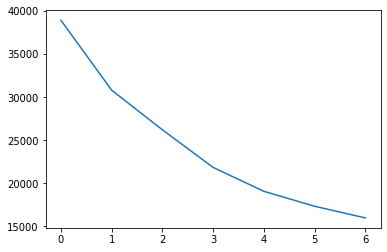

In [23]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [25]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5628999060330067
For n_clusters=3, the silhouette score is 0.5253337364354052
For n_clusters=4, the silhouette score is 0.5198491123736672
For n_clusters=5, the silhouette score is 0.4909502065663725
For n_clusters=6, the silhouette score is 0.3747626707197959
For n_clusters=7, the silhouette score is 0.37514245716897854
For n_clusters=8, the silhouette score is 0.37032079706925747


In [26]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=50)
kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3, random_state=50)

In [27]:
# assign the label
df['cluster_id'] = kmeans.labels_
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster_id
0,C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12,1
1,C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12,1
4,C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12,1
5,C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12,1


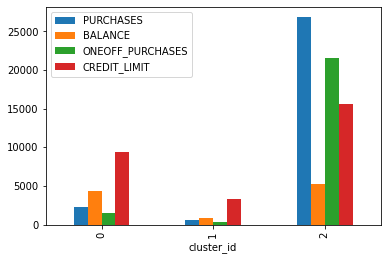

In [28]:
#CLuster Profiling
df[['cluster_id','PURCHASES','BALANCE','ONEOFF_PURCHASES','CREDIT_LIMIT']].groupby('cluster_id').mean().plot(kind='bar')
plt.show()

- cluster2 customers uses credit card more
- cluster0 customers uses credit card very less
- cluster1 customers uses credit card more than cluster0 but less than cluster 1

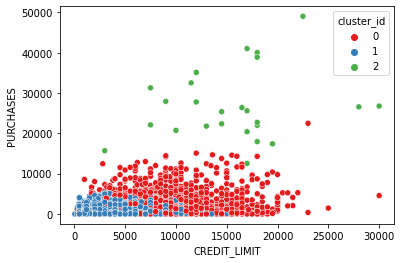

In [29]:
#plot data with seaborn
sns.scatterplot(x = 'CREDIT_LIMIT', y = 'PURCHASES', hue = 'cluster_id', data = df, palette = 'Set1')
plt.show()

Conclusion:
- Based on the elbow curve as well as the silhouette analysis, 3 seemed to be the optimal number of clusters for this dataset. So, I have built KMeans model with 3 clusters and clustered the records into 3 clusters.
- Based on the scatter plot, it seem like the records got clustered properly.

References:
- https://www.kaggle.com/arjunbhasin2013/ccdata
- https://www.kaggle.com/pardhasaradhireddy/creditcard-clustering